The Gurney flap is a small plate attached to or near the trailing edge of an airfoil, perpendicular to the flow on the pressure side.
Being counterintuitive to the idea of a streamlined body, the Gurney flap was invented more or less accidentally by race car driver Dan Gurney.

There are two basic (and somewhat overlapping) explanations for the lift-enhancing effect:

- The flap effectively increases camber [1], decelerating flow on the pressure side and accelerating flow on the suction side.
- The flap decelerates the flow on the pressure side right until the edge and leads to a pressure difference between suction and pressure side which in turn leads to an increased circulation [2].

However, the flow is rather complex and includes unsteady vortex-shedding[3] at the trailing edge.

To model the effects of a Gurney flap with viiflow, a single virtual displacement element is used depending on the position of the Gurney flap. 
The effect of Gurney flap position and height is analyzed and compared to the experimental results.
As far as the author knows, this is the first numerical analysis of Gurney flaps using a panel method.
The possibility of modeling the effect of a Gurney flap using a change in the Kutta condition of a panel method has been proposed in [2], but no function that correlates the Kutta condition (or a step in pressure) to the Gurney flap height is given.

The effect of Gurney flaps on the lift of an airfoil are surprisingly well predicted with viiflow.
This does not hold for the drag, though.
The drag increase for Gurney flaps that are not at the trailing edge can be computed with similar accuracy compared to a fully-turbulent RANS solution, but the coefficients were significantly overpredicted. 
For Gurney flaps right at the trailing edge, the drag cannot be computed using the wake boundary layer at this point, and the additional drag due to the Gurney flap is estimated using the local pressure at the flap.


## Experiments
The most comprehensive experimental analysis to date on an airfoil can be found in [7] where the S903 airfoil has been analyzed.
The coordinates of the airfoil can be found in [8], the paneling has been increased near the trailing edge.
Gurney flap position, height and influence of transition location have been evaluated.
In [4] some of these experimental results are compared with computational results with a fully-turbulent RANS solver. 
A note on these experimental results: the legend in the drag polar plot in [7], Fig. 6, is wrong.
Here, the plots have been changed assuming decreasing drag at higher lift coefficients with decreasing chord position. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
os.environ["OMP_NUM_THREADS"] = "1"

colors = ['k','k','k','k','k','k','k','k','k']
marks = ['o','^','v','<','>','d','^','^','^']

## Results
In all cases, viiflow accurately predicts the increase in lift and change in maximum lift.
The drag coefficient is less accurately predicted.

Where the Gurney flap is right at the trailing edge, the increase in drag is invisible to viiflow without further modifications.
In viiflow, the drag is calculated using the Squire-Young formula using the wake boundary layer development.
The wake boundary layer development depends on its initialization at the trailing edge, which is done by adding the momentum and displacement thickness of suction and pressure side and a weighted average of the shear-stress.
At this point, the modeling of the flow at the trailing edge is insufficient to describe the development of the wake behind a Gurney flap. 
However, the increase in drag seems to be largely dependent on the pressure difference at the Gurney flap [6].
Adding the pressure afterwards to the drag coefficient markedly improves the drag prediction.
In fact, the resulting polar matches the experiments better than the results of a Gurney flap at .9c or .95c.

If the transition is forced early on, the increase in drag matches the results of the RANS calculations better, though still with a significant drag bucket at low AOA. 
Without forced transition, the results do not get closer to the experimental results but vary significantly over the lift coefficient.
Both computational methods overpredict the increase in drag.

In [2]:
# We go through the experiments using the list below,
# using hgv, the vector of gurney flap heights
# and using pchord, the position of the gurney flap
N = 180
#AF = vft.repanel_spline(vft.read_selig("S903RF.dat"),int(N)) # this is refined using XFOIL paneling
AF = vft.repanel(vft.read_selig("S903RF.dat"),int(N),REFLIMS=[1.0,1.0,0.8,1.0],KAPFAC=.5,REFVAL=3,LEFAC=5,TEFAC = .5)

# Virtual displacement
hgv = np.asarray([0.0,0.005,0.01,0.02,0.02,0.02,0.02,0,0.01])
pchord = [1,1,1,1,.95,.9,.9,.9,-1.0]
forced = [0,0,0,0,0,0,1,1,0]

pol = []
AOARANGE = []
AOARANGE.append(np.arange(4.5,-13,-0.5))
AOARANGE.append(np.arange(5,18,0.5))

# Go over experiment setup
for i in range(len(hgv)):
    hg = hgv[i] 
    pc = pchord[i]

    # Gurney flap displacement
    vd = 0*AF[0,:]
    if pc>=1.0:
        index_gf = N-1
        index_gfp = N-2
    elif pc<=-1.0:
        index_gf = 0
        index_gfp = 1
    else:
        for k in range(1,AF.shape[1]):
            if AF[0,-k]<pc:
                index_gf = N-k
                index_gfp = N-k-1
                break
    vd[index_gf] = hg


    # Solver Setup
    RE = 1.0e6
    AOA0 = AOARANGE[0]
    # Not sure why they say "Mach less than 0.2", with the chord length and RE of 1e6 its 0.1.
    Mach = 0.1 
    # ncrit = 8 is a better fit to the end of the drag bucket for the non-gurney airfoil
    s = vf.setup(Re=RE,Ma = Mach,ncrit=8) 
    s.iterate_wakes = False
    s.itermax = 100
    s.silent = True
    # Use incompressible boundary layer calculation.
    s.incompressible_bl = 1
    s.equal_wakes = 1.0 # A bit more wake than default for 1 element airfoils

    alv = []
    clv = []
    cdv = []
    cdvg = []
    cdvg2 = []

    for j in range(2): # aoa up and down
        
        init = True
        
        for alpha in AOARANGE[j]:
            s.alpha = alpha
            
            if init:
                # Set-up and initialize based on inviscid panel solution
                (p,bl,x) = vf.init(AF,s)
                x[p.foils[0].N::p.foils[0].N+p.wakes[0].N-1]+=0.03#2*vd[-1]
                xn = x.copy()
                
                # Trigger transition a bit upstream of the GF
                if hg>0:
                    if pc>0:
                        xtrans = p.foils[0].X[0,index_gf]-0.0025
                        vf.set_forced_transition(bl,p,[],[xtrans])
                    else:
                        xtrans = p.foils[0].X[0,index_gf]-0.0025
                        vf.set_forced_transition(bl,p,[xtrans],[])

                # For the forced transition comparison use values near leading edge
                if forced[i]:
                    vf.set_forced_transition(bl,p,[.02],[.05])
                init = False

            res = None
            grad = None
            [xn,flag,res,grad,_] = vf.iter(xn,bl,p,s,res,grad,[vd])
            # Plot geometry

            nres=np.sqrt(np.dot(res.T,res))

            if flag>0:
                # Add to end or start of polar list
                if j == 1:pos = len(alv)
                else: pos = 0
                
                # Add pressure at gf. cp = 1-ue²/2
                # cp_before: 1-0, cpafter: 1-ue²/2, cd: cp_before-cp_after
                ue_gf = bl[0].bl_fl.nodes[index_gf].ue
                ue_gfp = bl[0].bl_fl.nodes[index_gfp].ue
                cdvg.insert(pos,hg*(0.5*ue_gf**2))
                cdvg2.insert(pos,hg*(0.5*(ue_gfp**2)))

                alv.insert(pos,alpha)
                clv.insert(pos,p.CL)
                cdv.insert(pos,bl[0].CD)
                #print('AL: %f CL: %f CD: %f' % (alpha,p.CL,bl[0].CD) )
            else:
                init = True
                #print('Unsolved AOA %f'%alpha)

    pol.append({'CL': np.asarray(clv), 'CD': np.asarray(cdv), 'CDg':np.asarray(cdvg),'CDg2':np.asarray(cdvg2), 'hg': hg, 'al': np.asarray(alv)})


 xi=0.980374,delta=0.027279,theta=0.026419,ue=0.620450,typ=turbulent,
 res=[-0.117498,0.0131212,0.000825192]
 dx=[0.111129,-1.32902,0.156738]
 x=[0.0264194,0.62045,0.0777311] 
 lam=0.015534 H=1.032530 HS=1.973798.

 xi=0.979795,delta=0.030015,theta=0.012937,ue=0.889416,typ=turbulent,
 res=[-0.0651117,0.0182498,0.000756686]
 dx=[-0.0126155,0.275447,-0.0192787]
 x=[0.0129368,0.889416,0.0529701] 
 lam=0.256367 H=2.320137 HS=1.533128.

 xi=0.979628,delta=0.030440,theta=0.013859,ue=0.866505,typ=turbulent,
 res=[-0.0326703,0.0122574,0.000301803]
 dx=[0.00258816,-0.0604532,0.00404684]
 x=[0.0138589,0.866505,0.0544269] 
 lam=0.892453 H=2.196400 HS=1.547424.

 xi=0.978439,delta=0.034602,theta=0.012587,ue=0.819552,typ=turbulent,
 res=[-0.183002,0.0642407,0.0023488]
 dx=[-0.27837,5.32667,-0.427443]
 x=[0.0125869,0.819552,0.0543552] 
 lam=0.011304 H=2.749082 HS=1.505047.

 xi=0.979858,delta=0.028052,theta=0.010664,ue=0.961564,typ=turbulent,
 res=[-0.00640255,0.00336919,3.06124e-05]
 dx=[0.00097204

Text(0.5, 0, 'CD')

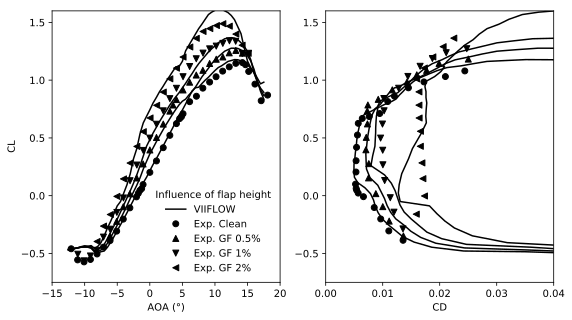

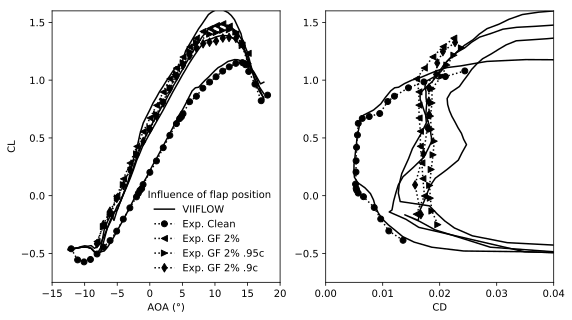

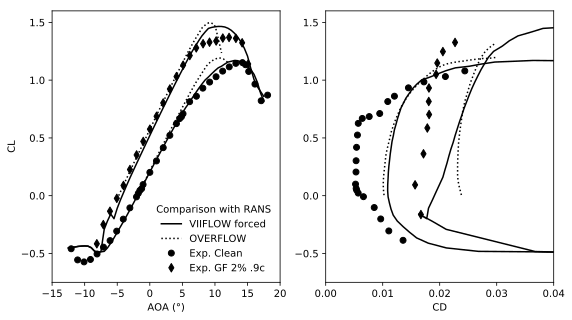

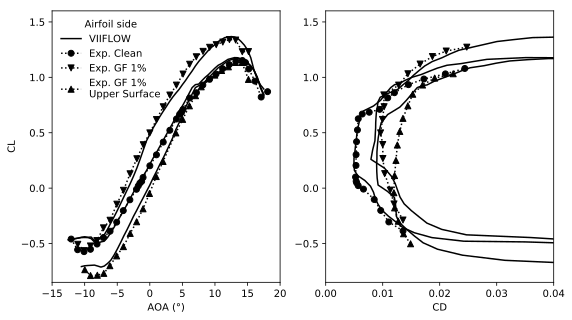

In [3]:
matplotlib.rcParams['figure.figsize'] = [9, 5]
fig,ax = plt.subplots(1,2)
cmap = plt.get_cmap("tab10")

# Part one, influence of height
namesVF = ['VIIFLOW',None,None,None,\
          None,None,\
          'VIIFLOW forced',None,\
          None]

linestyle_vf = ['-','-','-','-','-','-','-','-','-']

for k in range(4):
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    ax[1].plot(pol[k]['CD']*1+1*(pol[k]['CDg']),pol[k]['CL'],color=colors[k])
    #ax[1].plot(pol[k]['CD']*1+1*(pol[k]['CDg2']),pol[k]['CL'],color='m')


namesEXP = ['Exp. Clean','Exp. GF 0.5%','Exp. GF 1%','Exp. GF 2%','Exp. GF 2% .95c',\
            'Exp. GF 2% .9c','Exp. GF 1%\nUpper Surface']
for k in range(4):
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],'o',color = colors[k],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],'o',color = colors[k],marker=marks[k])

ax[0].legend(frameon=False,title='Influence of flap height')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part two, influence of chord position
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [0,3,4,5]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    if k>3: useg=0
    else: useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[k])
    #ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg2'],pol[k]['CL'],color='m')
    kcol+=1

kcol = 0
for k in [0,3,4,5]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],marker=marks[k])
    kcol+=1

ax[0].legend(frameon=False,title = 'Influence of flap position')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part three, comparison with fully-turbulent RANS
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [6,7]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[kcol],label = namesVF[k],linestyle=linestyle_vf[k])
    if k>3: useg=0
    else: useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[kcol],linestyle=linestyle_vf[k])
    kcol+=1
    
# Add CFD results from thesis
names = ['Clean Exp.','OVERFLOW','GF Exp',None]
linestyle = ['o',':','o',':']
for k in [1,3]:
    Data = np.genfromtxt('GurneyS903Lift.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],linestyle[k],color = colors[k],label = names[k])
    Data = np.genfromtxt('GurneyS903Polar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],linestyle[k],color = colors[k],label = names[k])    

kcol = 0
for k in [0,5]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],'o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],'o',color = colors[kcol],marker=marks[k])
    kcol+=1



ax[0].legend(frameon=False,title = 'Comparison with RANS')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.75,1.6)
ax[0].set_ylim(-.75,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


# Part four, influence of upper/lower
fig,ax = plt.subplots(1,2)
kcol = 0
for k in [0,2,8]:
    ax[0].plot(pol[k]['al'],pol[k]['CL'],'-',color=colors[k],label = namesVF[k])
    useg=1
    ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg'],pol[k]['CL'],color=colors[k])
    #ax[1].plot(pol[k]['CD']*1+useg*pol[k]['CDg2'],pol[k]['CL'],color='m')
    kcol+=1

kcol = 0
for k in [0,2,6]:
    Data = np.genfromtxt('S903GurneyCL.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[0].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],label = namesEXP[k],marker=marks[k])
    Data = np.genfromtxt('S903GurneyPolar.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax[1].plot(Data.T[0],Data.T[1],':o',color = colors[kcol],marker=marks[k])
    kcol+=1

ax[0].legend(frameon=False,title = 'Airfoil side')
ax[0].set_xlim(-15,20)
ax[1].set_xlim(0,0.04)
ax[1].set_ylim(-.85,1.6)
ax[0].set_ylim(-.85,1.6)
ax[0].set_xlabel('AOA (°)')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')


## Pressure Distribution
In [7] the pressure coefficients over the airfoil surface is given for a lift coefficient of 0.7.
The effect of the Gurney flap on the pressure is well predicted.
For the 1c Gurney flap, the step in pressure at the trailing edge smaller in the simulations, but the global pressure distribution matches well.
For the .9c configuration the step matches quite well, but the decrease in speed before the flap is underpredicted.

The transition seems to occur rather sooner on the suction side in the experiments.
In fact, it seems to occur around .05c regardless of Gurney flap position (though it should be a pressure distribution without forced transition), but maybe something else is going at this location.
On the pressure side, the transition does not seem to occur as suddenly as it occurs in the simulations.
This may explain the difference in surface speed in the .9c configuration.

0.7241260183942891
0.717923124154237
0.6951876509930545


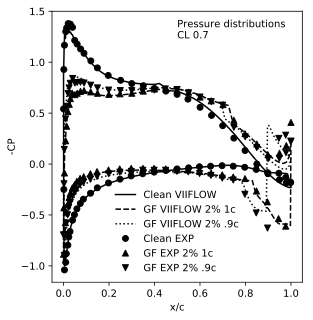

In [5]:
#N = 240 #220 good for gfs/S903RF, 180 good for both, 280 good for both, too
#AF = vft.repanel_spline(vft.read_selig("S903RF.dat"),N)

AF = vft.repanel(vft.read_selig("S903RF.dat"),int(N),REFLIMS=[1.0,1.0,0.8,1.0],KAPFAC=.5,REFVAL=3,LEFAC=5,TEFAC = .5)
matplotlib.rcParams['figure.figsize'] = [4.5, 5]

# Pressure comparison
hgv = [0.0,0.02,0.02]
pchord = [1,1,0.9]
alphas = [4.5+0.3,0.176-2*np.pi*0.02,1.115*4.3] # ->CL=0.7, read form above
lines = ['-','--',':']

fig,ax = plt.subplots(1,1)
names = ['Clean VIIFLOW', 'GF VIIFLOW 2% 1c','GF VIIFLOW 2% .9c']
for k in range(len(hgv)):
    hg = hgv[k] 
    pc = pchord[k]
    alpha = alphas[k]
    
    vd = 0*AF[0,:]

    if pc>=1.0:
        index_gf = N-1
    else:
        for j in range(1,AF.shape[1]):
            if AF[0,-j]<pc:
                index_gf = N-j
                break
    vd[index_gf] = hg
    
    s = vf.setup(Re=1e6,Ma = 0.1,ncrit=8) 
    s.alpha = alpha
    s.itermax = 300
    s.iterate_wakes = False
    s.incompressible_bl = 1
    s.silent=True
    (p0,bl0,x0) = vf.init(AF,s)
    if k==2: s.alpha *= 1/3
    x0[p0.foils[0].N::p0.foils[0].N+p0.wakes[0].N-1]+=0.1
    if hg>0:
        xtrans = p0.foils[0].X[0,index_gf]-0.01
        vf.set_forced_transition(bl0,p0,[],[xtrans])
    [x,flag,res,grad,_] = vf.iter(x0,bl0,p0,s,None,None,[vd])

    plt.plot(p0.foils[0].X[0,:],np.power(p0.gamma_viscid[0:p0.foils[0].N],2)-1,label=names[k],color = colors[k],linestyle=lines[k])
    print(p0.CL)

names = ['Clean EXP', 'GF EXP 2% 1c','GF EXP 2% .9c']
for k in range(3):
    Data = np.genfromtxt('S903GurneyCP.csv',skip_header=1,delimiter=",",usecols=[2*k,2*k+1])
    ax.plot(Data.T[0],Data.T[1],'o',color = colors[k],label = names[k],marker=marks[k])
ax.legend(frameon=False)
ax.set_xlabel('x/c')
ax.set_ylabel('-CP')
ax.text(.5,.9,'Pressure distributions\nCL 0.7',
        horizontalalignment='left',
        transform=ax.transAxes);



[1] Liu, Tianshu, and Javier Montefort. "Thin-airfoil theoretical interpretation for Gurney flap lift enhancement." Journal of Aircraft 44.2 (2007): 667-671.

[2] Jeffrey, David, Xin Zhang, and David W. Hurst. "Aerodynamics of Gurney flaps on a single-element high-lift wing." Journal of Aircraft 37.2 (2000): 295-301.

[3] Troolin, D. R., E. K. Longmire, and W. T. Lai. "Time resolved PIV analysis of flow over a NACA 0015 airfoil with Gurney flap." Experiments in Fluids 41.2 (2006): 241-254.

[4] Coder, James George. "CFD Investigation of Unsteady Rotorcraft Airfoil Aerodynamics." (2010).

[5] Storms, Bruce L., and Cory S. Jang. "Lift enhancement of an airfoil using a Gurney flap and vortex generators." Journal of Aircraft 31.3 (1994): 542-547.

[6] Jeffrey, David, Xin Zhang, and David W. Hurst. "Aerodynamics of Gurney flaps on a single-element high-lift wing." Journal of Aircraft 37.2 (2000): 295-301.

[7] Maughmer, Mark D., and Götz Bramesfeld. "Experimental investigation of Gurney flaps." Journal of Aircraft 45.6 (2008): 2062-2067.

[8] Somers, Dan M. "Effects of Airfoil Thickness and Maximum Lift Coefficient on Roughness Sensitivity: 1997--1998." No. NREL/SR-500-36336. National Renewable Energy Lab., Golden, CO (US), 2005.